# Test Video Pipeline for Challenge Video

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

Disable notebook autoscrolling

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Distortion correction and perspective transform

In [3]:
# Make a list of test images
images = glob.glob('test_images/ch*.jpg')

undist_images = []
for fname in images:
    img = mpimg.imread(fname)
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    undist_images.append(img_undist)

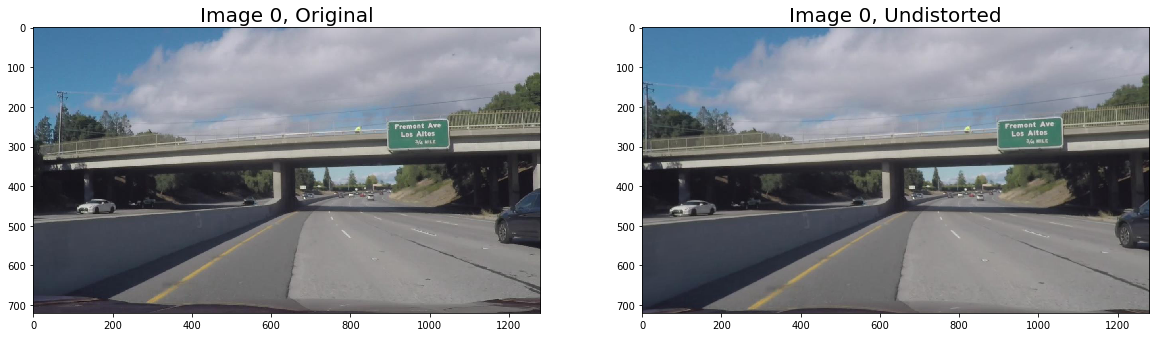

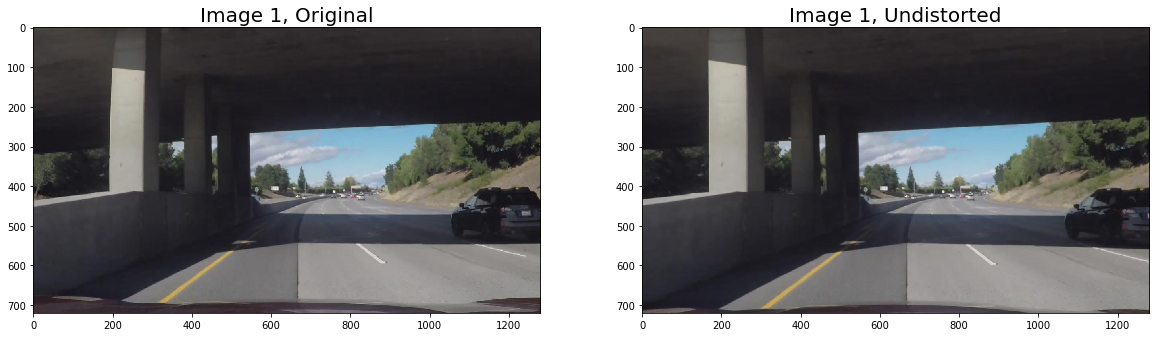

In [4]:
# Visualize undistortion
for i, fname in enumerate(images[0:2]):
    img_original = mpimg.imread(fname)
    img_undist = undist_images[i]
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img_original)
    ax1.set_title('Image {}, Original'.format(i), fontsize=20)
    ax2.imshow(img_undist)
    ax2.set_title('Image {}, Undistorted'.format(i), fontsize=20)

## Perspective transform

In [5]:
def draw_rectangle(img, corners, color=[255, 0, 0], thickness=3):
    """
    Draw a rectangle on an image
    
    The rectangle is defined by 4 'corners'.
    """
    img = np.copy(img)
    cv2.line(img, (corners[0,0],corners[0,1]), (corners[1,0],corners[1,1]), color, thickness)
    cv2.line(img, (corners[1,0],corners[1,1]), (corners[2,0],corners[2,1]), color, thickness)
    cv2.line(img, (corners[2,0],corners[2,1]), (corners[3,0],corners[3,1]), color, thickness)
    cv2.line(img, (corners[3,0],corners[3,1]), (corners[0,0],corners[0,1]), color, thickness)
    return img

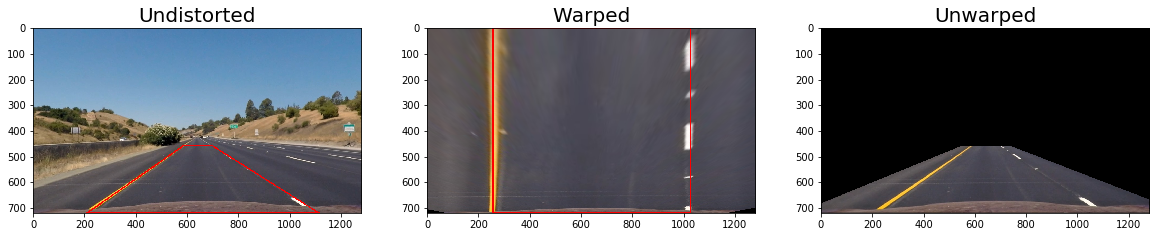

In [6]:
src = np.float32([[584, 458], [209, 720], [1113, 720], [698, 458]])
dst = np.float32([[256, 0], [256, 720], [1024, 720], [1024, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

img = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])
img_undist = cv2.undistort(img, mtx, dist, None, mtx)
img_warped = cv2.warpPerspective(img_undist, M, img_size, flags=cv2.INTER_LINEAR)
img_warped_inv = cv2.warpPerspective(img_warped, Minv, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(draw_rectangle(img_undist, src))
ax1.set_title('Undistorted', fontsize=20)
ax2.imshow(draw_rectangle(img_warped, dst))
ax2.set_title('Warped', fontsize=20)
ax3.imshow(img_warped_inv)
ax3.set_title('Unwarped', fontsize=20)

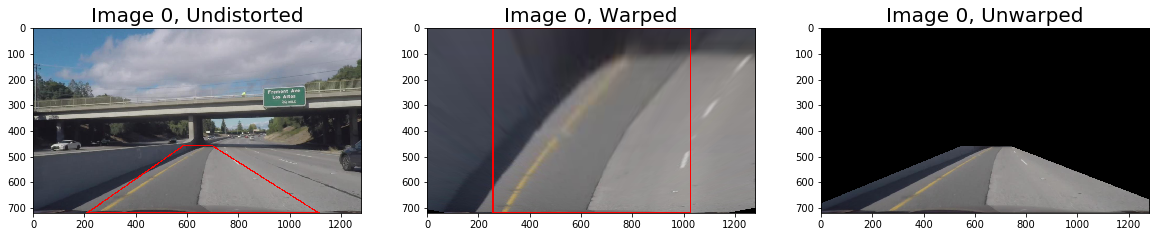

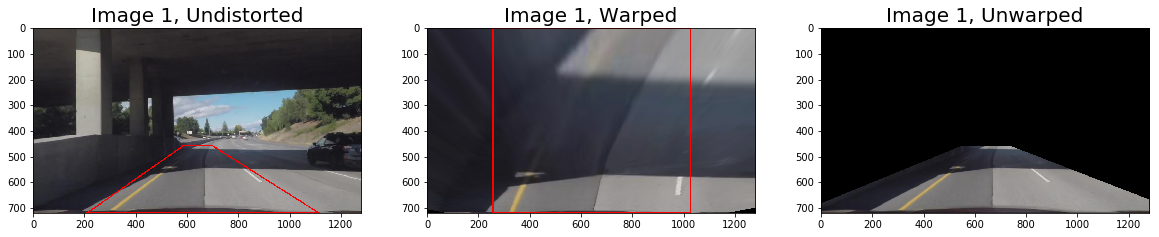

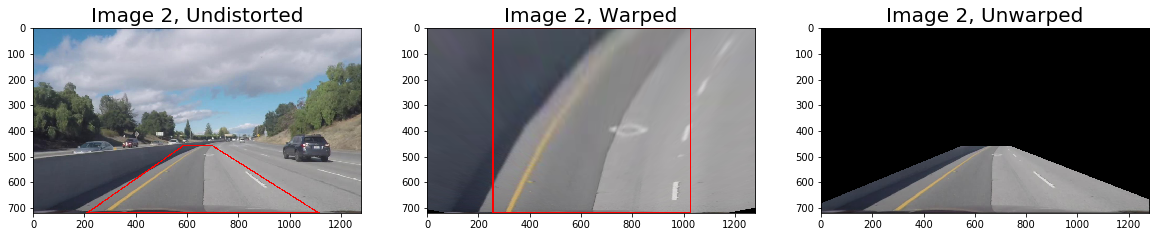

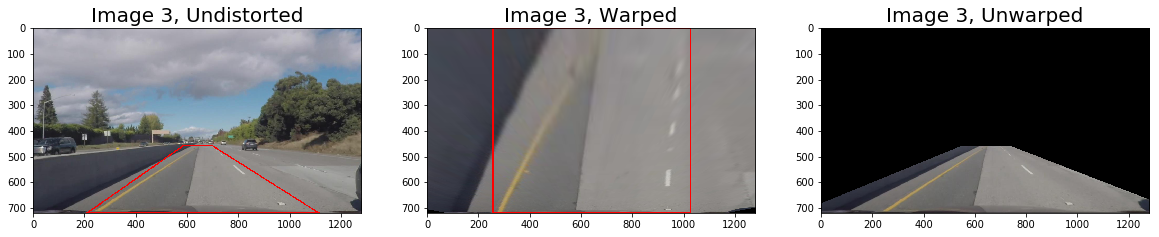

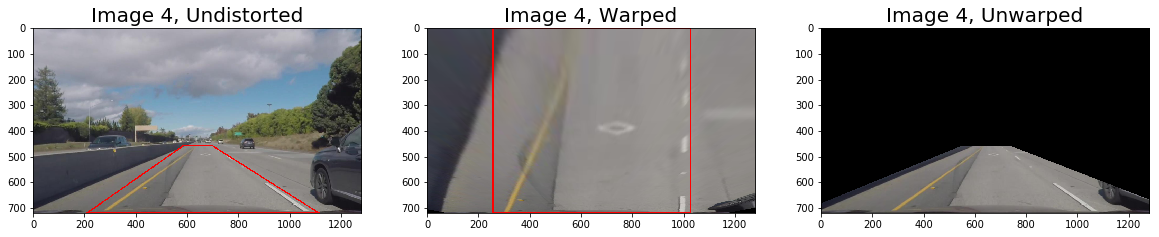

In [7]:
# Visualize undistortion and perspective transform
for i in range(len(undist_images)):
    img_undist = undist_images[i]
    img_warped = cv2.warpPerspective(img_undist, M, img_size, flags=cv2.INTER_LINEAR)
    img_warped_inv = cv2.warpPerspective(img_warped, Minv, img_size, flags=cv2.INTER_LINEAR)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(draw_rectangle(img_undist, src))
    ax1.set_title('Image {}, Undistorted'.format(i), fontsize=20)
    ax2.imshow(draw_rectangle(img_warped, dst))
    ax2.set_title('Image {}, Warped'.format(i), fontsize=20)
    ax3.imshow(img_warped_inv)
    ax3.set_title('Image {}, Unwarped'.format(i), fontsize=20)

## Color threshold

In [8]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def single_channel_pipeline(img, cspace, channel, threshold):
    """
    Apply single channel color threshold on an RGB image
    
    The function converts 'img' to a single channel on a new color
    space, specified by 'channel' and 'cspace'. Then a binary image
    is obtained based on 'threshold'.
    """
    RGB2cspace = getattr(cv2, 'COLOR_RGB2{}'.format(cspace))
    img_gray = cv2.cvtColor(img, RGB2cspace)[:,:,channel]
    img_norm = clahe.apply(img_gray)
   
    # Threshold color channel
    img_binary = np.zeros_like(img_norm)
    img_binary[(img_norm >= threshold[0]) & (img_norm <= threshold[1])] = 1
    
    return img_gray, img_norm, img_binary

In [9]:
# Parameters
settings = []
settings.append({'cspace': 'HLS', 'channel': 1, 'threshold': (190, 255)})
settings.append({'cspace': 'HSV', 'channel': 2, 'threshold': (190, 255)})
settings.append({'cspace': 'LAB', 'channel': 2, 'threshold': (150, 255)})

def multi_channel_pipeline(img):
    """
    Apply multi-channel color thresholds on an RGB image
    """
    com_binary = np.zeros_like(img[:,:,0])
    for s in settings:
        img_gray, img_norm, img_binary = single_channel_pipeline(img, s['cspace'], s['channel'], s['threshold'])
        com_binary += img_binary
    
    com_binary[(com_binary>1)] = 1
    return com_binary

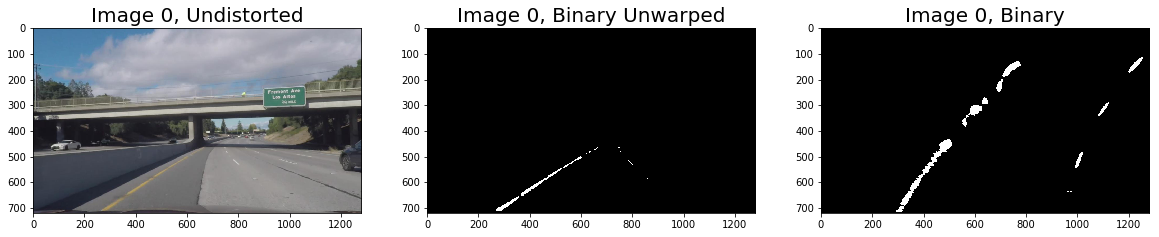

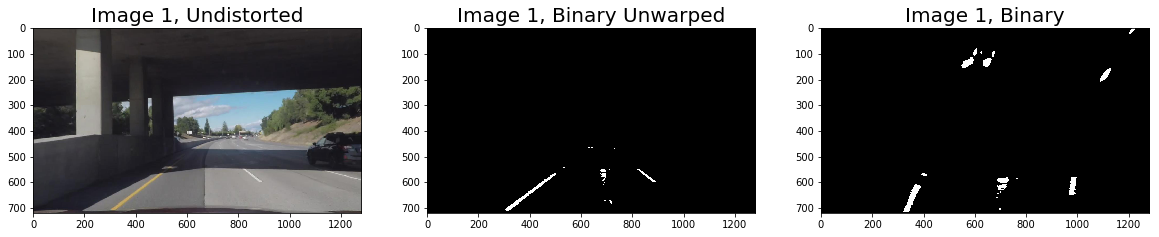

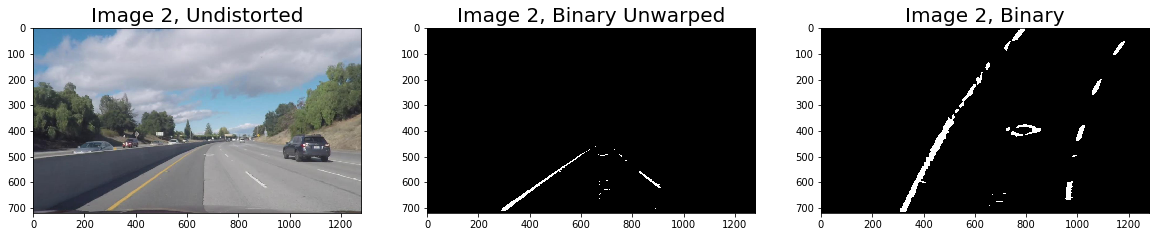

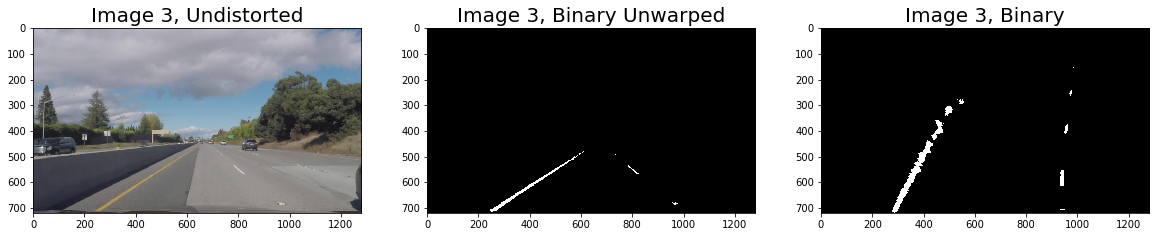

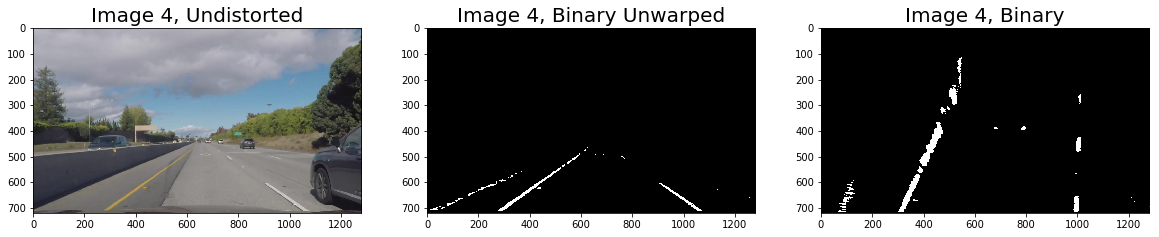

In [10]:
# Visualize multi channel threshold

binary_warped_images = []
for i in range(len(undist_images)):
    img_undist = undist_images[i]
    img_warped = cv2.warpPerspective(img_undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    img_binary_warped = multi_channel_pipeline(img_warped)
    img_binary_unwarped = cv2.warpPerspective(img_binary_warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    binary_warped_images.append(img_binary_warped)
        
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    ax1.imshow(img_undist)
    ax1.set_title('Image {}, Undistorted'.format(i), fontsize=20)
    ax2.imshow(img_binary_unwarped, cmap='gray')
    ax2.set_title('Image {}, Binary Unwarped'.format(i), fontsize=20)
    ax3.imshow(img_binary_warped, cmap='gray')
    ax3.set_title('Image {}, Binary'.format(i), fontsize=20)

## Lane lines detection

### Sliding windows

In [11]:
def sliding_window(binary_warped, nwindows = 9, margin = 75, minpix = 50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    if ((len(left_lane_inds)>0) & (len(right_lane_inds)>0)):
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Draw the fitted curve
        left_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(left_pts), isClosed=False, color=(255,255,0), thickness=3)
        cv2.polylines(out_img, np.int_(right_pts), isClosed=False, color=(255,255,0), thickness=3)
    else:
        left_fit, right_fit = None, None
    
    return left_fit, right_fit, out_img

In [12]:
def look_ahead_filter(binary_warped, left_fit, right_fit, margin = 75):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    if ((len(left_lane_inds)>0) & (len(right_lane_inds)>0)):
        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        # Draw the fitted curve
        left_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        right_pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
        cv2.polylines(out_img, np.int_(left_pts), isClosed=False, color=(255,255,0), thickness=3)
        cv2.polylines(out_img, np.int_(right_pts), isClosed=False, color=(255,255,0), thickness=3)
    else:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        left_fit, right_fit = None, None
        
    return left_fit, right_fit, out_img    

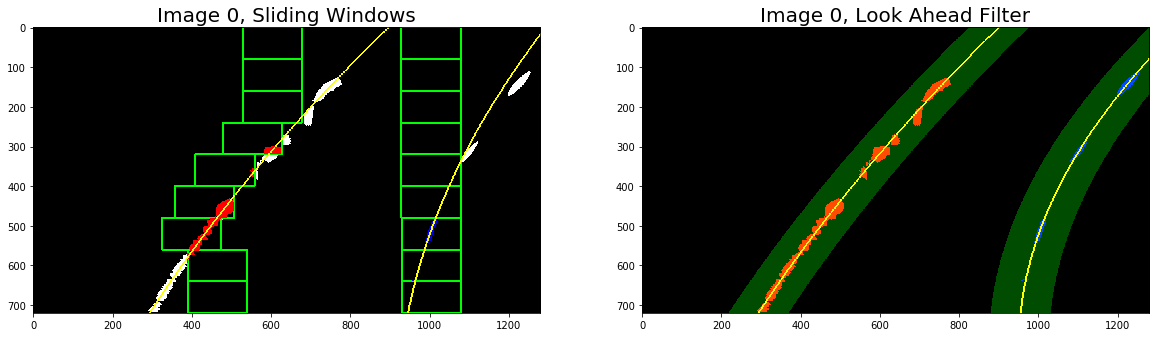

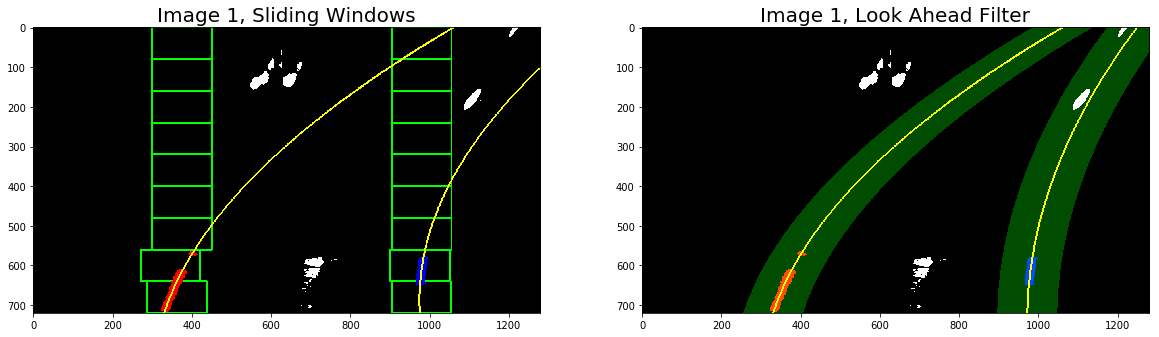

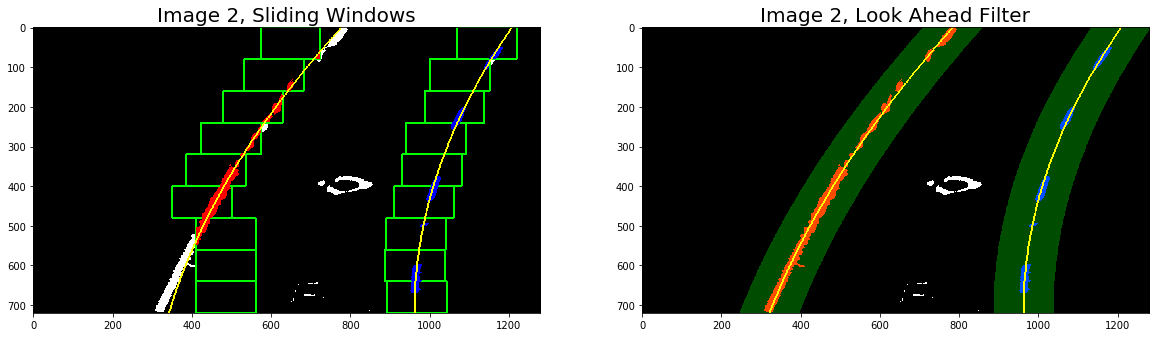

In [13]:
for i in range(len(binary_warped_images[0:3])):
    img_binary_warped = binary_warped_images[i]
    left_fit, right_fit, out_img_window = sliding_window(img_binary_warped)
    left_fit, right_fit, out_img_filter = look_ahead_filter(img_binary_warped, left_fit, right_fit)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(out_img_window)
    ax1.set_title('Image {}, Sliding Windows'.format(i), fontsize=20)
    ax2.imshow(out_img_filter)
    ax2.set_title('Image {}, Look Ahead Filter'.format(i), fontsize=20)

## Curvature calculation and drawing

In [14]:
def draw_lines(img_undist, left_fit, right_fit, xm_per_pix = 3.7/700, ym_per_pix = 30/720):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img_undist).astype(np.uint8)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_undist.shape[0]-1, img_undist.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    dist_x = right_fitx-left_fitx
    dist_range = [np.min(dist_x), np.max(dist_x)]
    dev = np.std(dist_x)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_undist.shape[1], img_undist.shape[0])) 
    
    # Combine the result with the original (undistorted) image
    out_img = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)     
    
    # Calculate radius of curvature in meters
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
#     left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
#     right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    center_fitx = np.mean([left_fitx, right_fitx], axis=0)
    center_fit_cr = np.polyfit(ploty*ym_per_pix, center_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
#     left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
#     right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    center_curverad = ((1 + (2*center_fit_cr[0]*y_eval*ym_per_pix + center_fit_cr[1])**2)**1.5) / np.absolute(2*center_fit_cr[0])


    # Calculate vehicle offset in meters
    mid_image = (img_undist.shape[1]-1)/2
    mid_lane = (left_fitx[-1] + right_fitx[-1])/2
    offset = (mid_image - mid_lane) * xm_per_pix
    
    # Display lane curvature and vehicle position 
    if offset>0:
        text_offset = 'Vehicle is %.2fm right of center'%(offset)
    else:
        text_offset = 'Vehicle is %.2fm left of center'%(np.abs(offset))       
    text_curvature = 'Curvature = %.0fm'%(center_curverad) 
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(out_img, text_curvature, (50,50), font, 1.2, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(out_img, text_offset, (50,100), font, 1.2, (255,255,255), 2, cv2.LINE_AA)    
#     cv2.putText(out_img, 'dist= (%.0f, %.0f)'%(dist_range[0], dist_range[1]), (50,150), font, 1.2, (255,255,255), 2, cv2.LINE_AA)
#     cv2.putText(out_img, 'std= %.0f'%(dev), (50,200), font, 1.2, (255,255,255), 2, cv2.LINE_AA)
    
    return out_img

## Line Class

In [15]:
class Line():
    """
    Define a class to receive the characteristics of each line detection
    """
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_left_xfitted = []     
        self.recent_right_xfitted = []     
        #average x values of the fitted line over the last n iterations
        self.best_left_x = None 
        self.best_right_x = None 
        #polynomial coefficients averaged over the last n iterations
        self.best_left_fit = None  
        self.best_right_fit = None
        # image size
        self.img_size = None
        
    def sanity_check(self, left_fit, right_fit):
        """
        Check that the detected lane lines are convincing, if
            1. they are separated by approximately the right distance horizontally
            2. they are roughly parallel
        """
        # Generate x and y values of the detected lane lines 
        ploty = np.linspace(0, self.img_size[0]-1, self.img_size[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        # Set the threshod
        dist_lane = 768    # lane line is about 768 pix wide, based on perspective transform 
        std_threshod = 140  # max std value for the horizontal distance
        dist_x = right_fitx - left_fitx
        
        # Sanity check
        if ((np.max(dist_x) > dist_lane+150) | (np.min(dist_x) < dist_lane-468) |
            (np.std(dist_x) > std_threshod)):
            check = False
        else:
            check = True 
            
        return check, left_fitx, right_fitx, ploty

    
    def find_line(self, binary_warped, n_iter = 5):
        """
        Find lane lines in a binary warped image
        
        If a lane was detected previously, use a look-ahead filter to search within a window 
        around the previous detection. 
        If the sanity check shows that the detected lines are problematic, retain the previous 
        line positions; otherwise, the detected lines are smoothened out using a low-pass filter 
        over 'n_iter' past frames.
        """
        self.img_size = binary_warped.shape
                
        if self.detected == False:
            left_fit, right_fit, out_img = sliding_window(binary_warped) 
        else:
            left_fit, right_fit, out_img = look_ahead_filter(binary_warped, self.best_left_fit, 
                                                             self.best_right_fit)

        if ((left_fit!=None) & (right_fit!=None)):
            # If lines were found, then perform sanity check
            check, left_fitx, right_fitx, ploty = self.sanity_check(left_fit, right_fit)    
            if check == True:
                # The lane lines were successfully detected
                self.detected = True
                # Insert the new x values of the fitted line to the front of the list
                self.recent_left_xfitted.insert(0, left_fitx)
                self.recent_right_xfitted.insert(0, right_fitx)
                # If the list has more than n elements, remove the last one
                if len(self.recent_left_xfitted) > n_iter:
                    self.recent_left_xfitted.pop() 
                    self.recent_right_xfitted.pop()

                # Update the averaged x values over the last n iterations
                self.best_left_x = np.mean(self.recent_left_xfitted, axis=0)
                self.best_right_x = np.mean(self.recent_right_xfitted, axis=0)
                # Update the averaged polynomial coefficients over the last n iterations
                self.best_left_fit = np.polyfit(ploty, self.best_left_x, 2)  
                self.best_right_fit = np.polyfit(ploty, self.best_right_x, 2)
            else:
                # The lane lines were problematic, use the previous polynomial coefficients
                self.detected = False
        else:
            # The lane lines were not found, use the previous polynomial coefficients
            self.detected = False
      
        return self.best_left_fit, self.best_right_fit, out_img

## Process pipeline

In [16]:
def process_image(image, diagnosis=True):
    """
    Apply process pipeline on test images
    
    NOTE: The output is a color image (3 channel) for processing video below
    """
    # Distortion correction
    img_undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perspective transform
    img_warped = cv2.warpPerspective(img_undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    # Color threshold
    img_binary_warped = multi_channel_pipeline(img_warped)
    
    # Lane lines detection
#     left_fit, right_fit, out_img = sliding_window(img_binary_warped) 
    left_fit, right_fit, out_img = line.find_line(img_binary_warped) 
    
    # Drawing
    result = draw_lines(img_undist, left_fit, right_fit)
    
    if diagnosis==True:
        # Create an image to draw the result and diagnosis images
        diag_w = result.shape[1]//2
        diag_h = result.shape[0]//2
        screen = np.ones((result.shape[0], result.shape[1]+diag_w, 3), dtype=np.uint8)*255
        
        # Draw result image to screen
        screen[0:result.shape[0], 0:result.shape[1]] = result
        
        # Draw diagnosis images to screen
        img_d1 = np.dstack((img_binary_warped, img_binary_warped, img_binary_warped))*255
        screen[0:diag_h-2, result.shape[1]+4:] = cv2.resize(img_d1, (diag_w-4, diag_h-2))
        screen[diag_h+2:, result.shape[1]+4:] = cv2.resize(out_img, (diag_w-4, diag_h-2))
        
        return screen
    else:
        return result

C:\Users\yuxin\Anaconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


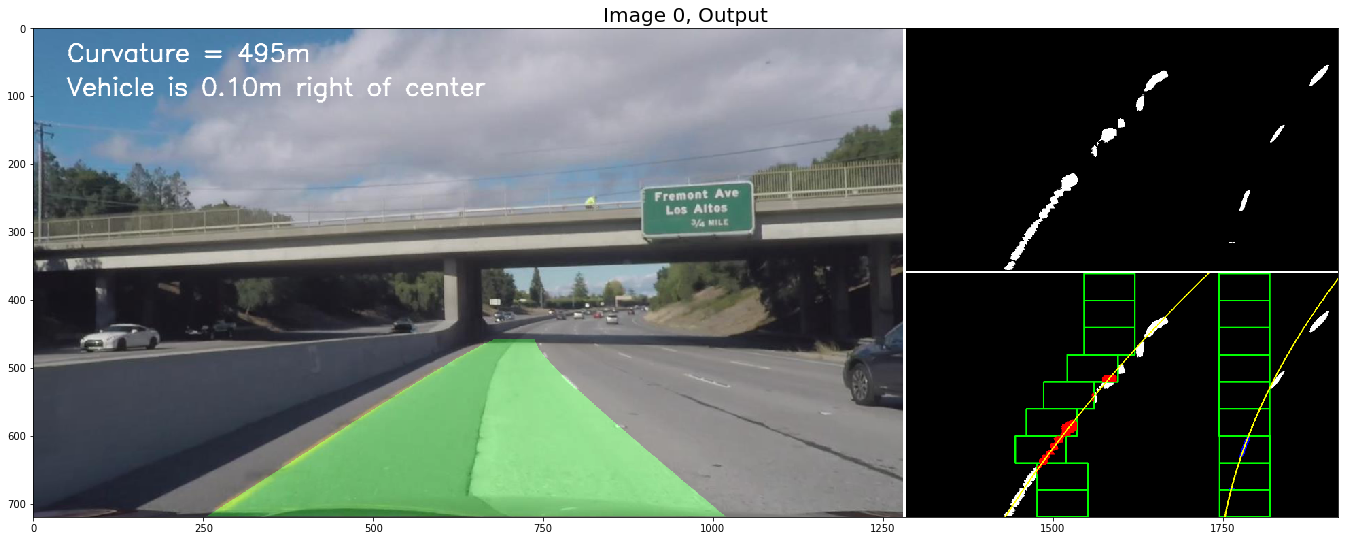

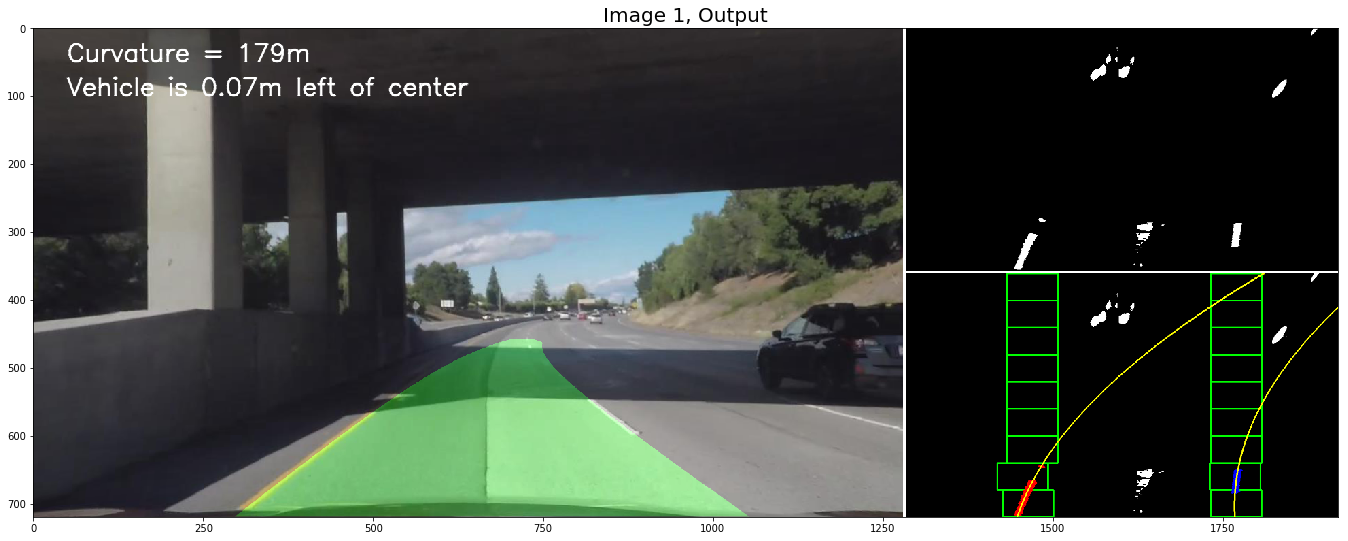

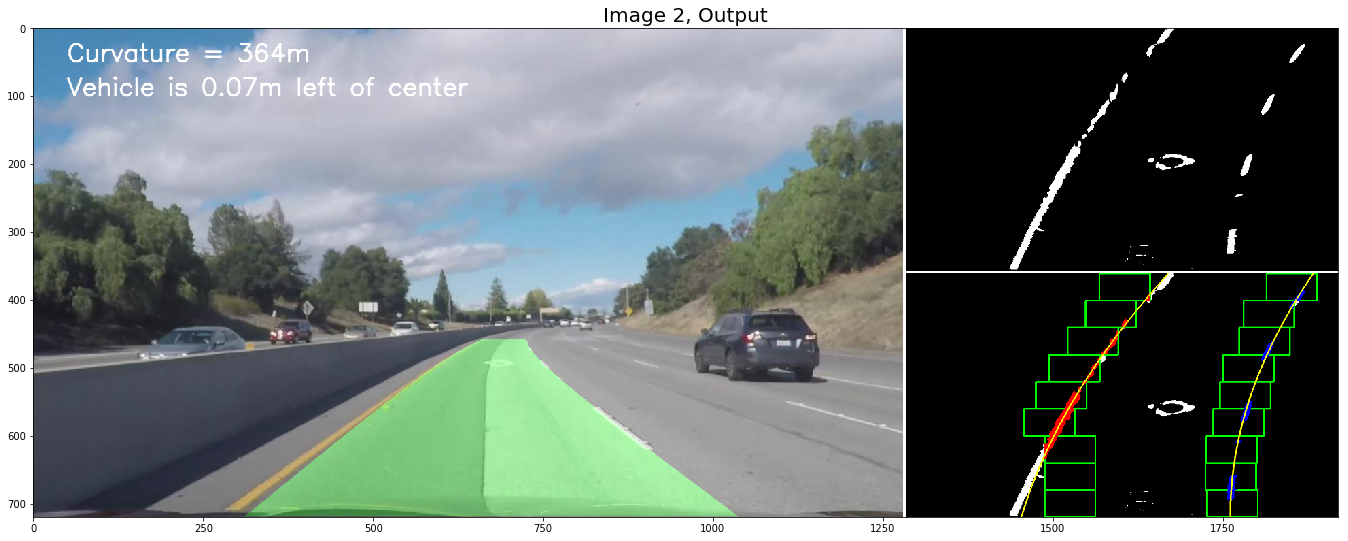

In [17]:
# Visualize undistortion
for i, fname in enumerate(images[0:3]):
    line = Line()
    img_original = mpimg.imread(fname)
    img_out = process_image(img_original)
    
    f, ax1 = plt.subplots(figsize=(24,9))
    ax1.imshow(img_out)
    ax1.set_title('Image {}, Output'.format(i), fontsize=20)

## Test on Videos

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [19]:
if not os.path.exists('test_videos_output'):
    os.mkdir("test_videos_output")

line = Line()
challenge_output = 'test_videos_output/challenge_video.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4


100%|█████████████████████████████████████████████████| 485/485 [01:26<00:00,  5.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

Wall time: 1min 28s


In [20]:
HTML("""
<video width="760" height="300" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

In [21]:
line = Line()
test_output = 'test_videos_output/project_video2.mp4'
clip1 = VideoFileClip("project_video.mp4")
test_clip = clip1.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video2.mp4
[MoviePy] Writing video test_videos_output/project_video2.mp4


100%|██████████████████████████████████████████████▉| 1260/1261 [04:15<00:00,  5.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video2.mp4 

Wall time: 4min 16s


In [22]:
HTML("""
<video width="760" height="300" controls>
  <source src="{0}">
</video>
""".format(test_output))